In [31]:
#pip install opencv-python

import cv2
import matplotlib.pyplot as plt

# Load the uploaded image
image_path = "/Users/satya/Documents/Abhilasha/OTH_Sem3/AR:VR/Project/Task_code/DC_1st floor.jpg"
floor_plan = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale for preprocessing
gray_floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2GRAY)

# Apply edge detection to highlight structural elements like walls and doors
edges = cv2.Canny(gray_floor_plan, threshold1=50, threshold2=150)

# Display the original image and the edge-detected version for analysis
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Floor Plan")
ax[0].axis("off")

ax[1].imshow(edges, cmap="gray")
ax[1].set_title("Edge Detection")
ax[1].axis("off")

plt.tight_layout()
plt.show()



In [32]:
# Detect contours in the edge-detected image to identify room boundaries
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw contours for visualization
contour_image = floor_plan.copy()

# Draw detected contours on the image
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green for contours

# Display the contour image to show detected room boundaries
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Room Boundaries")
plt.axis("off")
plt.show()

# Number of detected contours (potential rooms)
len(contours)


In [34]:
pip install pytesseract



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


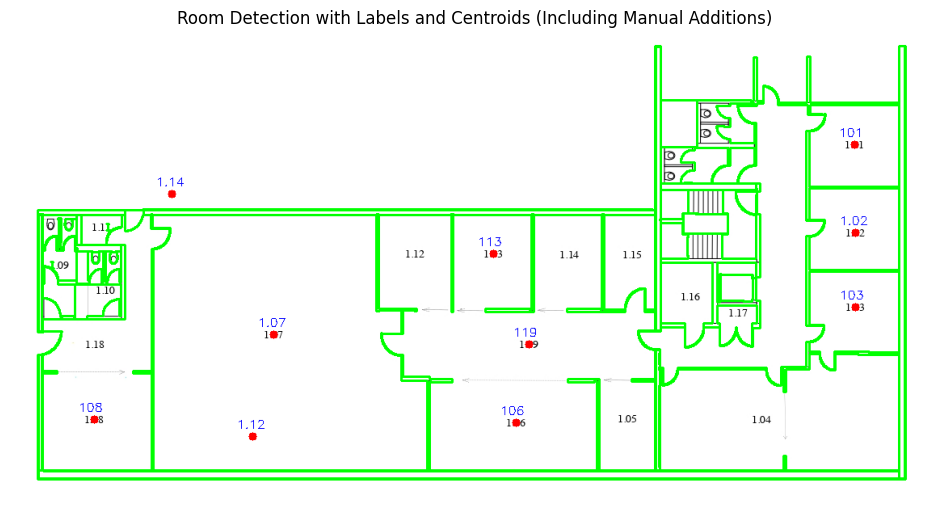

Final Room Labels: [('101', (1045, 139)), ('1.02', (1046, 248)), ('103', (1046, 340)), ('113', (598, 274)), ('119', (642, 386)), ('106', (626, 483)), ('1.07', (326, 374)), ('108', (104, 479)), ('1.12', (300, 500)), ('1.14', (200, 200))]


In [41]:
import pytesseract

# Apply adaptive thresholding to better segment the floor plan
thresholded = cv2.adaptiveThreshold(
    gray_floor_plan, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Detect contours with hierarchy to focus on nested shapes
contours, hierarchy = cv2.findContours(
    thresholded, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
)

# Filter contours based on area to exclude small artifacts
room_contours = [contour for contour in contours if cv2.contourArea(contour) > 500]

# Draw the filtered contours on a copy of the image
filtered_contour_image = floor_plan.copy()
cv2.drawContours(filtered_contour_image, room_contours, -1, (0, 255, 0), 2)

# Use OCR to extract room labels and their positions
ocr_results = pytesseract.image_to_data(
    floor_plan, output_type=pytesseract.Output.DICT
)

# Collect room labels and their bounding box centers
room_labels = []
for i, text in enumerate(ocr_results["text"]):
    if text.strip() and text.strip().replace(".", "").isdigit():
        x, y, w, h = (
            ocr_results["left"][i],
            ocr_results["top"][i],
            ocr_results["width"][i],
            ocr_results["height"][i],
        )
        room_labels.append((text.strip(), (x + w // 2, y + h // 2)))  # (label, center)

# Manually add missing rooms here
manual_rooms = [
    ("1.12", (300, 500)),  # Example: Room 1.20 at (500, 500)
    ("1.14", (200, 200)),  # Example: Room 1.21 at (600, 600)
]

# Combine detected and manually added rooms
room_labels.extend(manual_rooms)

# Draw OCR-detected room labels on the image
labeled_image = filtered_contour_image.copy()
for label, (cx, cy) in room_labels:
    cv2.putText(
        labeled_image,
        label,
        (cx - 20, cy - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 0, 0),
        1,
    )
    cv2.circle(labeled_image, (cx, cy), 5, (0, 0, 255), -1)  # Mark centroid

# Display the updated image with contours and room labels
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.title("Room Detection with Labels and Centroids (Including Manual Additions)")
plt.axis("off")
plt.show()

# Show final room labels (detected + manual additions)
print("Final Room Labels:", room_labels)

